### Building & Testing Models with Sample Dataset

### Setup workspace

In [1]:
# import required packages
import pandas as pd
import numpy as np
import sqlite3
import pymysql
from datetime import datetime
import time
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import scipy.stats as ss
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
import sklearn
import math
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import pickle
from sklearn.metrics import mean_absolute_error
import seaborn as sns

### Functions to clean the dfs

In [2]:
# Function to clean the Leavetimes df
# Based off of the CleaningNotebook cleaning methods
def clean_leavetimes(x):
    
    categorical_columns = x[["TRIPID","PROGRNUMBER","STOPPOINTID","PLANNEDTIME_ARR", 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR','ACTUALTIME_DEP','VEHICLEID']].columns
    # Convert data type to category for these columns
    for column in categorical_columns:
        x[column] = x[column].astype('category')
    
    # Converting dayofservice to datetime64
    x['DAYOFSERVICE'] = pd.to_datetime(x['DAYOFSERVICE'], infer_datetime_format=True)

    # Converting lastupdate to datetime64
    x['LASTUPDATE'] = pd.to_datetime(x['LASTUPDATE'], infer_datetime_format=True)
    
    return x

In [3]:
def clean_trips(x):
    
    # Converting dates to datetime64
    x['DAYOFSERVICE'] = pd.to_datetime(x['DAYOFSERVICE'], infer_datetime_format=True)
    x['LASTUPDATE'] = pd.to_datetime(x['LASTUPDATE'], infer_datetime_format=True)
    
    # Adding new features
    x['MONTH'] = x['DAYOFSERVICE'].dt.month
    x['DAY'] = x['DAYOFSERVICE'].dt.dayofweek
    x['HOUR'] = x['LASTUPDATE'].dt.hour
    
    # Creating an additional feature called Journey Time
    x['JOURNEY_TIME'] = x['ACTUALTIME_ARR'] - x['ACTUALTIME_DEP']
    
    # Removing Journey times less than or equal to 0
    x = x[x["JOURNEY_TIME"] >= 0]
    
    # Calling the remove outliers function
    x = x[~x.groupby('LINEID')['JOURNEY_TIME'].apply(is_outlier)]
    
    # Convert data type to category for these columns
    categorical_columns = x[["TRIPID","LINEID", "ROUTEID", "DIRECTION", "PLANNEDTIME_ARR","PLANNEDTIME_DEP", "ACTUALTIME_ARR", "ACTUALTIME_DEP", "NOTE"]].columns
    for column in categorical_columns:
        x[column] = x[column].astype('category')

    # Sorting df by LASTUPDATE
    x.sort_values('LASTUPDATE', inplace=True)
    
    return x

In [4]:
def clean_weather(x):
    
    x = x.drop(columns=["msl"])

    # Converting date to datetime
    x['date'] = pd.to_datetime(x['date'], infer_datetime_format=True)
    
    # Convert empty string to null pandas (to convert to float64)
    x = x.replace(r'^\s*$', np.NaN, regex=True)
    
    # Converting rain to float64
    x['rain'] = x['rain'].astype('float64')
    
    # Sorting df by date
    x.sort_values(by=['date'])
    return x

In [5]:
# Function to remove outliers

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

### 2.0 Reading in Leavetimes Dataset

In [ ]:
# Reading in the cleaned Leavetimes csv
df_leavetimes = pd.read_csv(r'C:\Users\jason\OneDrive - University College Dublin\Documents\MSc Computer Science\Summer Semester\Data\Notebooks\CleanedCSVs\rt_leavetimes_DB_2018_cleaned_sample.csv', index_col=[0])

In [ ]:
df_leavetimes.head(5)

In [ ]:
# Pass the leavetimes df through the cleaning function
df_leavetimes = clean_leavetimes(df_leavetimes)
df_leavetimes.head(5)

In [ ]:
df_leavetimes.dtypes

### 3.0 Read in weather CSV

In [6]:
#read in cleaned weather csc
df_weather = pd.read_csv(r'C:\Users\jason\OneDrive - University College Dublin\Documents\MSc Computer Science\Summer Semester\Data\Notebooks\CleanedCSVs\weather2018_cleaned.csv', index_col=[0])

In [7]:
df_weather.head(5)

,date,rain,temp,msl
0,2018-01-01 00:00:00,0.0,4.6,991.0
1,2018-01-01 01:00:00,0.1,4.7,991.1
2,2018-01-01 02:00:00,0.0,4.8,991.1
3,2018-01-01 03:00:00,0.0,4.9,990.7
4,2018-01-01 04:00:00,0.0,5.3,990.3


In [8]:
df_weather.dtypes

date     object
rain     object
temp    float64
msl     float64
dtype: object

In [9]:
# Sending the weather df to the cleaning function
df_weather = clean_weather(df_weather)
df_weather.head(5)

,date,rain,temp
0,2018-01-01 00:00:00,0.0,4.6
1,2018-01-01 01:00:00,0.1,4.7
2,2018-01-01 02:00:00,0.0,4.8
3,2018-01-01 03:00:00,0.0,4.9
4,2018-01-01 04:00:00,0.0,5.3


In [10]:
df_weather.dtypes

date    datetime64[ns]
rain           float64
temp           float64
dtype: object

### Merge Weather and LeaveTimes Dataset

In [ ]:
# Sorting in order to merge
df_leavetimes.sort_values('LASTUPDATE', inplace=True)
df_weather.sort_values('date', inplace=True)

In [ ]:
# Merging 
merged_data = pd.merge_asof(df_leavetimes, df_weather, left_on="LASTUPDATE", right_on="date")

In [ ]:
merged_data.head(5)

### 4.0 Read In Trips Data for merging

In [11]:
#read in cleaned trips data
df_trips = pd.read_csv(r'C:\Users\jason\OneDrive - University College Dublin\Documents\MSc Computer Science\Summer Semester\Data\Notebooks\CleanedCSVs\rt_trips_DB_2018_cleaned.csv', index_col=[0])

In [12]:
df_trips.shape

(1893367, 11)

In [13]:
df_trips.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LASTUPDATE,NOTE
0,1517961600000000000,6253783,68,68_80,1,87245,84600,87524.0,84600.0,1519819511000000000,",2967409,"
2,1517961600000000000,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,1519819511000000000,",2448968,"
3,1517961600000000000,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,1519819511000000000,",3094242,"
4,1517961600000000000,6253175,14,14_15,1,85383,81600,84682.0,81608.0,1519819511000000000,",2526331,"
5,1517961600000000000,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,1519819511000000000,",2966500,"


In [14]:
df_trips.shape

(1893367, 11)

In [15]:
# Converting Actual time to int64 to subtract for new feature Journey Time. (Error on model when JOURNEY_TIME was left as a float)

df_trips['ACTUALTIME_ARR'] = df_trips['ACTUALTIME_ARR'].astype("int64")
df_trips['ACTUALTIME_DEP'] = df_trips['ACTUALTIME_DEP'].astype("int64")

In [16]:
# Creating an additional feature called Journey Time
df_trips['JOURNEY_TIME'] = df_trips['ACTUALTIME_ARR'] - df_trips['ACTUALTIME_DEP']

In [17]:
df_trips.dtypes

DAYOFSERVICE        int64
TRIPID              int64
LINEID             object
ROUTEID            object
DIRECTION           int64
PLANNEDTIME_ARR     int64
PLANNEDTIME_DEP     int64
ACTUALTIME_ARR      int64
ACTUALTIME_DEP      int64
LASTUPDATE          int64
NOTE               object
JOURNEY_TIME        int64
dtype: object

#### 4.1 Examining/Visualising Outliers

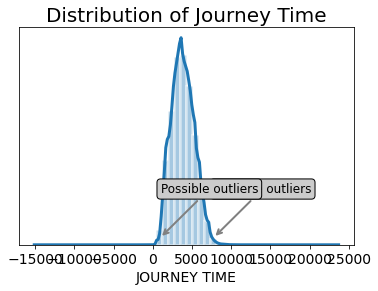

In [18]:
# histogram of Journey Time
ax = sns.distplot(df_trips.JOURNEY_TIME, hist=True, hist_kws={"edgecolor": 'w', "linewidth": 3}, kde_kws={"linewidth": 3})

# notation indicating a possible outlier
ax.annotate('Possible outliers', xy=(7800,0.00001), xytext=(7800,0.00007), fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

ax.annotate('Possible outliers', xy=(1000,0.00001), xytext=(1000,0.00007), fontsize=12,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('JOURNEY TIME', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Journey Time', fontsize=20);
plt.gca().axes.get_yaxis().set_visible(False)

Text(0.5, 1.0, 'JOURNEY TIME Box Plot')

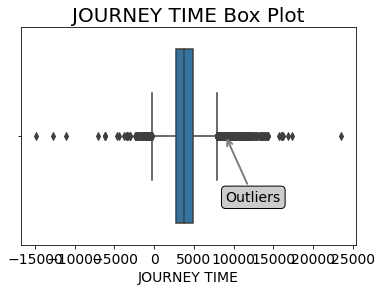

In [19]:
# box plot of Journey Time
ax = sns.boxplot(df_trips.JOURNEY_TIME)

# notation indicating an outlier
ax.annotate('Outliers', xy=(9000,0), xytext=(9000,0.3), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# xtick, label, and title
plt.xticks(fontsize=14)
plt.xlabel('JOURNEY TIME', fontsize=14)
plt.title('JOURNEY TIME Box Plot', fontsize=20)

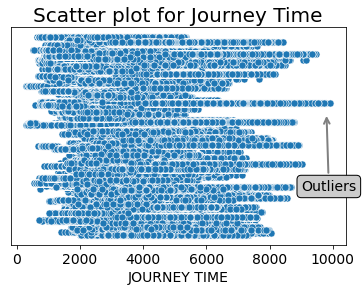

In [55]:
# scatter plot
ax = sns.scatterplot(x='JOURNEY_TIME', y='LINEID', data=df_trips, s=50)

# notations indicating an outlier

ax.annotate('Outliers', xy=(9800,50), xytext=(9000,100), fontsize=14,
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), bbox = dict(boxstyle="round", fc="0.8"))

# ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('JOURNEY TIME', fontsize=14)
plt.title('Scatter plot for Journey Time', fontsize=20);
plt.gca().axes.get_yaxis().set_visible(False)

#### 4.2 Cleaning Trips Dataset

In [21]:
# Pass the leavetimes df through the cleaning function
df_trips = clean_trips(df_trips)
df_trips.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LASTUPDATE,NOTE,JOURNEY_TIME,MONTH,DAY,HOUR
2079344,2018-01-01,5966704,44,44_38,1,49857,45000,49297,45011,2018-01-08 17:21:10,",2885439,",4286,1,0,17
2088511,2018-01-01,5962137,238,238_15,2,71075,69900,71068,69910,2018-01-08 17:21:10,",2817494,",1158,1,0,17
2088510,2018-01-01,5962095,7,7_66,1,55938,50400,56364,50351,2018-01-08 17:21:10,",2793690,",6013,1,0,17
2088509,2018-01-01,5962074,15A,15A_84,2,37341,35100,37027,35153,2018-01-08 17:21:10,",2988633,",1874,1,0,17
2088508,2018-01-01,5962009,123,123_36,2,62054,58800,62324,58827,2018-01-08 17:21:10,",1922708,",3497,1,0,17


In [22]:
# df_trips = df_trips.replace(np.nan, '', regex=True)
# df_trips.head(5)

In [23]:
df_trips.dtypes

DAYOFSERVICE       datetime64[ns]
TRIPID                   category
LINEID                   category
ROUTEID                  category
DIRECTION                category
PLANNEDTIME_ARR          category
PLANNEDTIME_DEP          category
ACTUALTIME_ARR           category
ACTUALTIME_DEP           category
LASTUPDATE         datetime64[ns]
NOTE                     category
JOURNEY_TIME                int64
MONTH                       int64
DAY                         int64
HOUR                        int64
dtype: object

In [24]:
df_trips.sort_values(by=['TRIPID'])

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LASTUPDATE,NOTE,JOURNEY_TIME,MONTH,DAY,HOUR
681660,2018-01-06,5955221,14,14_15,1,42553,37800,42078,37836,2018-01-15 08:25:25,",2513511,",4242,1,5,8
723197,2018-01-06,5955222,14,14_16,2,47867,43200,47707,43182,2018-01-15 08:25:25,",2513514,",4525,1,5,8
684398,2018-01-06,5955223,14,14_15,1,54105,49200,54128,49171,2018-01-15 08:25:25,",2513515,",4957,1,5,8
719581,2018-01-06,5955224,14,14_16,2,60094,55200,60025,55203,2018-01-15 08:25:25,",2429419,",4822,1,5,8
674864,2018-01-06,5955225,14,14_15,1,65751,61200,65332,61161,2018-01-15 08:25:25,",2513518,",4171,1,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422478,2018-12-26,8592206,67,67_6,2,61896,58500,62222,58545,2019-01-09 17:30:44,",2805863,",3677,12,2,17
28895,2018-12-30,8592206,67,67_6,2,61896,58500,63920,58522,2019-01-16 18:16:31,",2805863,",5398,12,6,18
438572,2018-12-26,8592207,67,67_4,1,67655,63900,68012,63877,2019-01-09 17:30:44,",2805865,",4135,12,2,17
57439,2018-12-30,8592207,67,67_4,1,67655,63900,67575,63955,2019-01-16 18:16:31,",2805865,",3620,12,6,18


### Practicing Modelling on route 68

In [25]:
## Creating a df based off of lineid 68
route68 = (df_trips[df_trips['LINEID'] =='68'])

In [26]:
route68.shape

(10097, 15)

In [27]:
# Sorting route68 by LASTUPDATE
route68.sort_values('LASTUPDATE', inplace=True)

In [28]:
# Merging weather and trips
merged_data_trips = pd.merge_asof(route68, df_weather, left_on="LASTUPDATE", right_on="date")

In [29]:
merged_data_trips.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LASTUPDATE,NOTE,JOURNEY_TIME,MONTH,DAY,HOUR,date,rain,temp
0,2018-01-01,5956344,68,68_80,1,53390,50100,53575,50151,2018-01-08 17:21:10,",2962287,",3424,1,0,17,2018-01-08 17:00:00,0.0,3.7
1,2018-01-01,5959989,68,68_79,1,75492,72000,75018,72114,2018-01-08 17:21:10,",2969165,",2904,1,0,17,2018-01-08 17:00:00,0.0,3.7
2,2018-01-01,5970736,68,68_80,1,58926,55500,58752,55532,2018-01-08 17:21:10,",2966843,2966843,",3220,1,0,17,2018-01-08 17:00:00,0.0,3.7
3,2018-01-01,5969019,68,68_66,2,88740,87000,88639,87140,2018-01-08 17:21:10,",2818436,",1499,1,0,17,2018-01-08 17:00:00,0.0,3.7
4,2018-01-01,5969008,68,68_85,2,40029,36600,39454,36662,2018-01-08 17:21:10,",2967848,",2792,1,0,17,2018-01-08 17:00:00,0.0,3.7


In [30]:
merged_data_trips.dtypes

DAYOFSERVICE       datetime64[ns]
TRIPID                   category
LINEID                   category
ROUTEID                  category
DIRECTION                category
PLANNEDTIME_ARR          category
PLANNEDTIME_DEP          category
ACTUALTIME_ARR           category
ACTUALTIME_DEP           category
LASTUPDATE         datetime64[ns]
NOTE                     category
JOURNEY_TIME                int64
MONTH                       int64
DAY                         int64
HOUR                        int64
date               datetime64[ns]
rain                      float64
temp                      float64
dtype: object

In [31]:
# % missing on new feature JOURNEY_TIME
journey_missing = 100 * (merged_data_trips['JOURNEY_TIME'].isna().sum()/merged_data_trips.shape[0])
journey_missing

0.0

### Building and Testing Models on Sample Route 68

Classification metrics can't handle a mix of multiclass and continuous targets, which means accuracy score is only for classification problems. For regression problems we can use: R2 Score, MSE (Mean Squared Error), RMSE (Root Mean Squared Error).

In [32]:
# X for the input data to be predicted on
X = merged_data_trips[["MONTH", "DAY", "HOUR", "rain", "temp"]]
# y for the out/goal set
y = merged_data_trips[["JOURNEY_TIME"]]

In [33]:
X.dtypes

MONTH      int64
DAY        int64
HOUR       int64
rain     float64
temp     float64
dtype: object

In [34]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=20)

print("original range is: ", merged_data_trips.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  10097
training range (70%):	 rows 0 to 7067
test range (30%): 	 rows 7067 to 10097


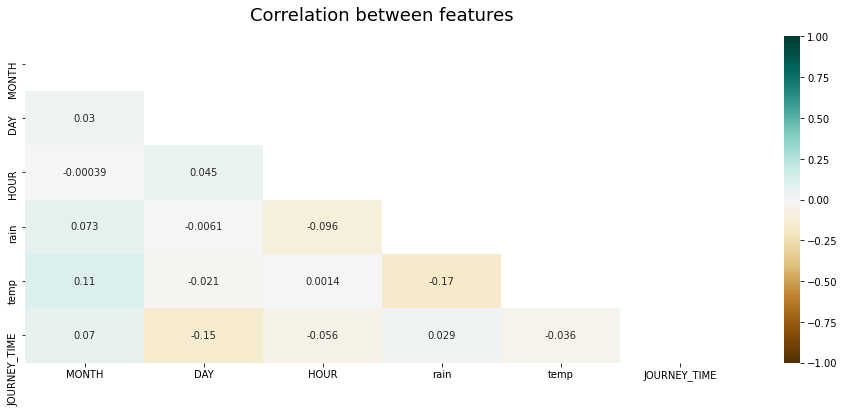

In [35]:
# Visualising of the correlation between the features
trainingSubset = pd.concat([X_train, y_train], axis=1)
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(trainingSubset.corr(), dtype=np.bool))
heatmap = sns.heatmap(trainingSubset.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation between features', fontdict={'fontsize':18}, pad=16);

### Decision Tree 

In [36]:
# Generating r2 score for decision tree model
decisionTree = DecisionTreeRegressor()
decisionTree.fit(X_train, y_train)
predictions = decisionTree.predict(X_test)
decisionTreeR2 = r2_score(y_test, predictions)
decisionTreeR2

0.08474230096563995

In [37]:
# Generating mean absolute error score for decision tree model
decisionTreeMAE = mean_absolute_error(y_test, predictions)
decisionTreeMAE

640.3614685218299

In [38]:
# Calculating Root Mean Square Error
DecisionTreeMSE = sklearn.metrics.mean_squared_error(y_test, predictions)
                           
DecisionTreeRMSE = math.sqrt(DecisionTreeMSE)
DecisionTreeRMSE

890.4221708081423

### Random Forest Regressor

In [39]:
# Generating r2 score for random forest model
randForestModel = RandomForestRegressor(n_estimators = 100, random_state=10)
randForestModel.fit(X_train, y_train.values.ravel())
predictionTest = randForestModel.predict(X_test)
randForestR2 = r2_score(y_test, predictionTest)
randForestR2

0.08394478227690261

In [40]:
# Generating mean absolute error score for Random Forest model
randForestMAE = mean_absolute_error(y_test, predictionTest)
randForestMAE

640.7485802013845

In [41]:
# Calculating Root Mean Square Error for Random Forest
RandforestMSE = sklearn.metrics.mean_squared_error(y_test, predictionTest)
                           
RandForestRMSE = math.sqrt(RandforestMSE)
RandForestRMSE

890.8100253412929

- Checking feature importances

In [42]:
# Checking for important features
feature_list = list(X.columns)
importance = pd.DataFrame({'feature': feature_list, 'importance':randForestModel.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
1,DAY,0.515601
4,temp,0.195983
2,HOUR,0.138595
0,MONTH,0.126286
3,rain,0.023535


### K-Nearest Neighbour

In [43]:
# Generating r2 score for K-nearest Neighbour
knn_model = KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, y_train.values.ravel())
knnTest = knn_model.predict(X_test)
knnR2 = r2_score(y_test, knnTest)
knnR2

0.05635402027693448

In [44]:
# Generating mean absolute error score for k-nearest neighbour model
knnMAE = mean_absolute_error(y_test, knnTest)
knnMAE

654.9197689768977

In [45]:
# Calculating Root Mean Square Error for Knn
KnnMSE = sklearn.metrics.mean_squared_error(y_test, knnTest)
                           
KnnRMSE = math.sqrt(KnnMSE)
KnnRMSE

904.1257047830821

### Linear Regression

In [46]:
# Generating r2 score for Linear Regression
linearModel = LinearRegression().fit(X_train, y_train.values.ravel())
linearModel
linear_prediction = linearModel.predict(X_test)
linearRegR2 = r2_score(y_test, linear_prediction)
linearRegR2

0.03677754028115876

In [47]:
# Generating mean absolute error score for Linear Regression
linearRegMAE = mean_absolute_error(y_test, linear_prediction)
linearRegMAE

673.1984516691145

In [48]:
# Calculating Root Mean Square Error for Linear Regression
LinRegMSE = sklearn.metrics.mean_squared_error(y_test, linear_prediction)
                           
LinearRegRMSE = math.sqrt(LinRegMSE)
LinearRegRMSE

913.4558678306042

In [49]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", linearModel.coef_)
print("\nIntercept is: \n", linearModel.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, linearModel.coef_)))


Features are: 
 Index(['MONTH', 'DAY', 'HOUR', 'rain', 'temp'], dtype='object')

Coeficients are: 
 [ 21.55655277 -76.28000543 -10.1303155   34.3219319   -6.33432304]

Intercept is: 
 4285.8820148255845

Features and coeficients: 
 [('MONTH', 21.556552766834784), ('DAY', -76.28000542606075), ('HOUR', -10.130315499496259), ('rain', 34.321931897947806), ('temp', -6.334323041798498)]


- Printing Actual Death vs predicted based on train data

In [50]:
# calculate the prediction and threshold the value.
multiple_linreg_predictions_train = (linearModel.predict(X_train)) 

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    JOURNEY_TIME    Predicted
0            NaN  3957.945529
1         2904.0  4004.256302
2         3220.0  4067.254084
3            NaN  3897.738936
4         2792.0  3933.480778
..           ...          ...
95        3397.0  4121.431276
96        3276.0  3810.828932
97           NaN  4221.237697
98        3949.0  4137.496304
99        4144.0  4288.074332

[100 rows x 2 columns]


- Printing Actual Death vs predicted based on test data

In [51]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (linearModel.predict(X_test)) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    JOURNEY_TIME    Predicted
0         3424.0  3985.891367
1            NaN  4411.576675
2            NaN  3739.304595
3         1499.0  4258.117084
4            NaN  4081.428902
..           ...          ...
95           NaN  4189.975695
96           NaN  3913.373696
97        3911.0  4098.111309
98           NaN  3745.312674
99           NaN  4233.927521

[100 rows x 2 columns]


### Printing and Discussing Results

In [52]:
# Some more evaluation metrics.
print("==================== Predictive Model Accuracy - R2 Score =======================\n")
print("Decision Tree : ", decisionTreeR2)
print("Random Forest : ", randForestR2)
print("K-nearest Neighbour : ", knnR2)
print("Linear Regression : ", linearRegR2 )

print("\n==================== Predictive Model Accuracy - MAE Score =======================\n")
print("Decision Tree : ", decisionTreeMAE)
print("Random Forest : ", randForestMAE)
print("K-nearest Neighbour : ", knnMAE)
print("Linear Regression : ", linearRegMAE )

print("\n==================== Predictive Model Accuracy - RMSE Score =======================\n")
print("Decision Tree : ", DecisionTreeRMSE)
print("Random Forest : ", RandForestRMSE)
print("K-nearest Neighbour : ", KnnRMSE)
print("Linear Regression : ", LinearRegRMSE )

==================== Predictive Model Accuracy - R2 Score =======================

Decision Tree :  0.08474230096563995
Random Forest :  0.08394478227690261
K-nearest Neighbour :  0.05635402027693448
Linear Regression :  0.03677754028115876

==================== Predictive Model Accuracy - MAE Score =======================

Decision Tree :  640.3614685218299
Random Forest :  640.7485802013845
K-nearest Neighbour :  654.9197689768977
Linear Regression :  673.1984516691145

==================== Predictive Model Accuracy - RMSE Score =======================

Decision Tree :  890.4221708081423
Random Forest :  890.8100253412929
K-nearest Neighbour :  904.1257047830821
Linear Regression :  913.4558678306042


#### Decision Tree
- We get very good results from R2 score, MAE score and the RMSE score. 
- The decision tree is giving us very good results, we will likely use this method but will continue to test other predictive models first.

#### Random Forest
- Random Forest produces just as good results as decision tree for the R2 Score, MAE score and RMSE score, however the random forest takes up far more space and takes longer to run. The trade off between accuracy and time taken/storage is something we have to strongly consider, as we have very large data sets. 
- After testing the size of a decision tree vs a random forest, the random forest pickle file is approximately 6.4 times bigger than the size of a decision tree pickle file (455KB vs 2896KB)

#### Knn
- We have gotten poor results from the R2 score, MAE score and the RMSE score.
- Due to these poor results, we will disregard this method for our predictive models.

#### Linear Regression
- We are getting poor results from the linear regression for r2 scores but acceptable results for MAE and RMSE.
- However, these results do not compare to the decision tree or random forest results.

### Conclusion
- Based on the results above and after considering the trade off between accuracy and time taken/storage for the models, we believe <b>Random Forest</b> is the best option and we will be proceeding with this predictive model for the rest of our dataset.